# Questão 1
Considere o conjunto de dados disponível em breastcancer.csv, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset.

a. Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:
- Regressão logística (treinado com GD ou SGD);
- Análise do discriminante Gaussiano;
- Naive Bayes Gaussiano;

b. Para cada modelo criado, reporte valor médio e desvio padrão da acurácia
global e da acurácia por classe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Regressão logística - GD

In [2]:
class LogisticRegressionGD:
    def __init__(self, alpha=1e-1, num_epochs=1000):
        self.alpha = alpha
        self.num_epochs = num_epochs
        self.w = None
        self.mean = None
        self.std = None
        self.losses = []

    def sigmoid(self, z):
        z = (1) / (1 + np.exp(-z))
        return z

    def cross_entropy(self, y, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return loss
    
    def normalize(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return (X - self.mean) / self.std

    def fit(self, X, y):
        N = X.shape[0]
        X_norm = self.normalize(X)
        y = y.reshape(-1, 1)
        X_b = np.c_[np.ones((N, 1)), X_norm]
        self.w = np.random.randn(X_b.shape[1], 1)
        self.losses = []

        for epoch in range(self.num_epochs):
            z = X_b @ self.w
            y_pred = self.sigmoid(z)
            loss = self.cross_entropy(y, y_pred)
            self.losses.append(loss)
            gradient = (1 / N) * X_b.T @ (y_pred - y)
            self.w -= self.alpha * gradient
            # print(f"Época: {epoch}; Loss: {loss:.4f}")

    def predict(self, X):
        X_norm = (X - self.mean) / self.std
        X_b = np.c_[np.ones((X.shape[0], 1)), X_norm]
        probs = self.sigmoid(X_b @ self.w)
        return (probs >= 0.5).astype(int)

In [3]:
def accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def per_class_accuracy(y_true, y_pred):
    classes = np.unique(y_true)
    accs = {}
    for cls in classes:
        cls_idx = (y_true.flatten() == cls)
        accs[cls] = np.mean(y_pred.flatten()[cls_idx] == y_true.flatten()[cls_idx])
    return accs

def mean_per_class_accuracy(accs_por_classe, classes):
    per_class_avg = {}
    for cls in classes:
        cls_accs = [fold_acc.get(cls, 0.0) for fold_acc in accs_por_classe]
        per_class_avg[cls] = np.mean(cls_accs)
    return per_class_avg

def k_fold_split(X, y, k=10, seed=42):
    np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)

    fold_sizes = np.full(k, X.shape[0] // k)
    fold_sizes[:X.shape[0] % k] += 1

    current = 0
    folds = []

    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = idx[start:stop]
        train_idx = np.concatenate([idx[:start], idx[stop:]])
        folds.append((train_idx, val_idx))
        current = stop

    return folds

def split_train_test(X, y, train_size=0.7, seed=42):
    np.random.seed(seed)
    N = X.shape[0]
    indices = np.random.permutation(N)

    train_end = int(train_size * N)
    train_idx = indices[:train_end]
    test_idx = indices[train_end:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, y_train, X_test, y_test

def cross_validate_model(ModelClass, X, y, k=10, **kwargs):
    folds = k_fold_split(X, y, k)
    accuracies = []
    acc_class_0 = []
    acc_class_1 = []

    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = ModelClass(**kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc = accuracy(y_val, y_pred)
        accuracies.append(acc)

        accs = per_class_accuracy(y_val, y_pred)
        acc_class_0.append(accs.get(0, 0.0))
        acc_class_1.append(accs.get(1, 0.0))

        print(f"Fold {fold_idx + 1} - Acurácia: {acc:.4f} | Classe 0: {acc_class_0[-1]:.4f} | Classe 1: {acc_class_1[-1]:.4f}")

    print(f"\nAcurácia Global: Média = {np.mean(accuracies):.4f}, Desvio Padrão = {np.std(accuracies):.4f}")
    print(f"Acurácia Classe 0: Média = {np.mean(acc_class_0):.4f}, Desvio Padrão = {np.std(acc_class_0):.4f}")
    print(f"Acurácia Classe 1: Média = {np.mean(acc_class_1):.4f}, Desvio Padrão = {np.std(acc_class_1):.4f}")

    return accuracies, acc_class_0, acc_class_1


In [4]:
data = np.loadtxt('./breastcancer.csv', delimiter=',')

X = data[:, :-1]
y = data[:, -1].astype(int)

X_trainval, y_trainval, X_test, y_test = split_train_test(X, y, train_size=0.7)

In [5]:
alpha = 1e-1
num_epochs = 1000

print("Regressão Logística - GD")
print(f"\n[CONJUNTO DE VALIDAÇÃO]")	

accuracies_log_reg, acc_class_0_log_regr, acc_class_1_log_reg = cross_validate_model(LogisticRegressionGD,X=X_trainval, y=y_trainval, k=10, alpha=alpha, num_epochs=num_epochs)

Regressão Logística - GD

[CONJUNTO DE VALIDAÇÃO]
Fold 1 - Acurácia: 0.9750 | Classe 0: 1.0000 | Classe 1: 0.9333
Fold 2 - Acurácia: 0.9750 | Classe 0: 1.0000 | Classe 1: 0.8750
Fold 3 - Acurácia: 0.9500 | Classe 0: 1.0000 | Classe 1: 0.8182
Fold 4 - Acurácia: 0.9750 | Classe 0: 0.9600 | Classe 1: 1.0000
Fold 5 - Acurácia: 0.9750 | Classe 0: 1.0000 | Classe 1: 0.9286
Fold 6 - Acurácia: 0.9750 | Classe 0: 0.9600 | Classe 1: 1.0000
Fold 7 - Acurácia: 0.9750 | Classe 0: 0.9583 | Classe 1: 1.0000
Fold 8 - Acurácia: 0.9750 | Classe 0: 0.9630 | Classe 1: 1.0000
Fold 9 - Acurácia: 0.9231 | Classe 0: 0.9200 | Classe 1: 0.9286
Fold 10 - Acurácia: 0.9487 | Classe 0: 1.0000 | Classe 1: 0.8947

Acurácia Global: Média = 0.9647, Desvio Padrão = 0.0172
Acurácia Classe 0: Média = 0.9761, Desvio Padrão = 0.0265
Acurácia Classe 1: Média = 0.9378, Desvio Padrão = 0.0598


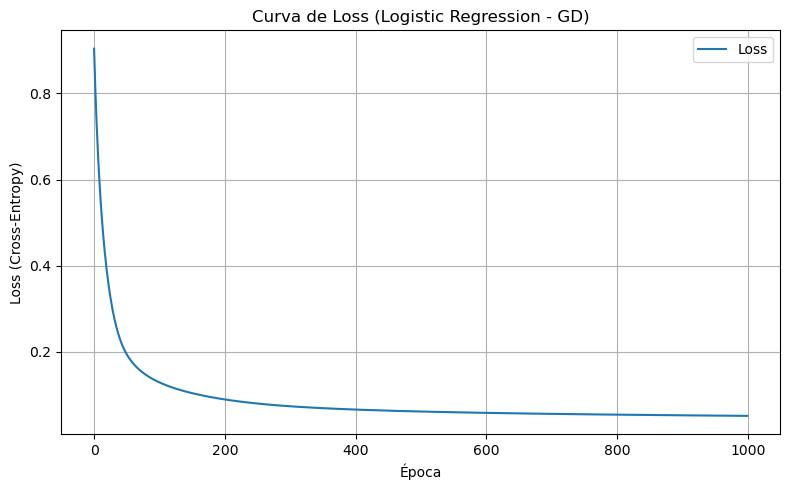

In [6]:
model_final = LogisticRegressionGD(alpha=alpha, num_epochs=num_epochs)
model_final.fit(X_trainval, y_trainval)

plt.figure(figsize=(8, 5))
plt.plot(model_final.losses, label='Loss')
plt.xlabel('Época')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Curva de Loss (Logistic Regression - GD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
y_test_pred = model_final.predict(X_test)


test_acc = accuracy(y_test, y_test_pred)

test_accs = per_class_accuracy(y_test, y_test_pred)
test_acc_class_0 = test_accs.get(0, 0.0)
test_acc_class_1 = test_accs.get(1, 0.0)

print(f"\n[CONJUNTO DE TESTE] Regressão Logística - GD (classificação binária)")
print(f"Acurácia Global: {test_acc:.4f}")
print(f"Acurácia Classe 0: {test_acc_class_0:.4f}")
print(f"Acurácia Classe 1: {test_acc_class_1:.4f}")


[CONJUNTO DE TESTE] Regressão Logística - GD (classificação binária)
Acurácia Global: 0.9474
Acurácia Classe 0: 0.9697
Acurácia Classe 1: 0.9167


## Análise do discriminante Gaussiano;

In [8]:
class GaussianDiscriminantAnalysis:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.priors = {}
        N, D = X.shape
        self.cov = np.zeros((D, D))

        for cls in self.classes:
            X_cls = X[y.flatten() == cls]
            self.means[cls] = np.mean(X_cls, axis=0)
            self.priors[cls] = X_cls.shape[0] / N
            self.cov += np.cov(X_cls, rowvar=False) * (X_cls.shape[0] - 1)

        self.cov /= (N - len(self.classes))
        self.cov_inv = np.linalg.inv(self.cov)

    def predict(self, X):
        scores = []
        for cls in self.classes:
            mean = self.means[cls]
            prior = self.priors[cls]
            score = X @ self.cov_inv @ mean - 0.5 * mean.T @ self.cov_inv @ mean + np.log(prior)
            scores.append(score)
        scores = np.array(scores)
        return np.argmax(scores, axis=0).reshape(-1, 1)

In [9]:
def accuracy_per_class(y_true, y_pred):
    classes = np.unique(y_true)
    accs = {}

    for c in classes:
        idx = (y_true == c)
        acc_c = np.mean(y_pred[idx] == y_true[idx])
        accs[c] = acc_c

    return accs

def compute_metrics(y_true, y_pred):
    global_acc = accuracy(y_true, y_pred)
    per_class_acc = accuracy_per_class(y_true, y_pred)
    return global_acc, per_class_acc


In [10]:
print("Análise Discriminante Gaussiana")
print(f"\n[CONJUNTO DE VALIDAÇÃO]")	
accuracies_gda, acc_class_0_gda, acc_class_1_gda = cross_validate_model(GaussianDiscriminantAnalysis, X_trainval, y_trainval, k=10)

Análise Discriminante Gaussiana

[CONJUNTO DE VALIDAÇÃO]
Fold 1 - Acurácia: 0.9000 | Classe 0: 1.0000 | Classe 1: 0.7333
Fold 2 - Acurácia: 0.9000 | Classe 0: 1.0000 | Classe 1: 0.5000
Fold 3 - Acurácia: 0.9250 | Classe 0: 1.0000 | Classe 1: 0.7273
Fold 4 - Acurácia: 0.9750 | Classe 0: 1.0000 | Classe 1: 0.9333
Fold 5 - Acurácia: 1.0000 | Classe 0: 1.0000 | Classe 1: 1.0000
Fold 6 - Acurácia: 1.0000 | Classe 0: 1.0000 | Classe 1: 1.0000
Fold 7 - Acurácia: 1.0000 | Classe 0: 1.0000 | Classe 1: 1.0000
Fold 8 - Acurácia: 0.9500 | Classe 0: 0.9630 | Classe 1: 0.9231
Fold 9 - Acurácia: 0.9487 | Classe 0: 1.0000 | Classe 1: 0.8571
Fold 10 - Acurácia: 0.9487 | Classe 0: 1.0000 | Classe 1: 0.8947

Acurácia Global: Média = 0.9547, Desvio Padrão = 0.0368
Acurácia Classe 0: Média = 0.9963, Desvio Padrão = 0.0111
Acurácia Classe 1: Média = 0.8569, Desvio Padrão = 0.1525


In [11]:
model_final = GaussianDiscriminantAnalysis()
model_final.fit(X_trainval, y_trainval)

y_test_pred = model_final.predict(X_test)

test_acc = accuracy(y_test, y_test_pred)
test_per_class = per_class_accuracy(y_test, y_test_pred)

print(f"\n[CONJUNTO DE TESTE - GDA (Classificação Binária)]")
print(f"Acurácia Global: {test_acc:.4f}")
print(f"Acurácia Classe 0: {test_per_class.get(0, 0):.4f}")
print(f"Acurácia Classe 1: {test_per_class.get(1, 0):.4f}")


[CONJUNTO DE TESTE - GDA (Classificação Binária)]
Acurácia Global: 0.9357
Acurácia Classe 0: 1.0000
Acurácia Classe 1: 0.8472


## Naive Bayes Gaussiano

In [12]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.means = {}
        self.variances = {}
        self.priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_c = X[y == cls]
            self.means[cls] = np.mean(X_c, axis=0)
            self.variances[cls] = np.var(X_c, axis=0)
            self.priors[cls] = X_c.shape[0] / X.shape[0]

    def _predict(self, x):
        posteriors = []
        for cls in self.classes:
            prior = np.log(self.priors[cls])
            mean = self.means[cls]
            variance = self.variances[cls]
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * variance) + (x - mean) ** 2 / variance)
            posterior = prior + likelihood
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X):
        return np.array([self._predict(x) for x in X])

In [13]:
print("Naive Bayes Gaussiano")
print(f"\n[CONJUNTO DE VALIDAÇÃO]")	
accuracies_nb, acc_class_0_nb, acc_class_1_nb = cross_validate_model(GaussianNaiveBayes, X_trainval, y_trainval, k=10)

Naive Bayes Gaussiano

[CONJUNTO DE VALIDAÇÃO]
Fold 1 - Acurácia: 0.9500 | Classe 0: 1.0000 | Classe 1: 0.8667
Fold 2 - Acurácia: 0.9000 | Classe 0: 1.0000 | Classe 1: 0.5000
Fold 3 - Acurácia: 0.9500 | Classe 0: 0.9655 | Classe 1: 0.9091
Fold 4 - Acurácia: 0.9250 | Classe 0: 0.9200 | Classe 1: 0.9333
Fold 5 - Acurácia: 1.0000 | Classe 0: 1.0000 | Classe 1: 1.0000
Fold 6 - Acurácia: 0.9250 | Classe 0: 0.9600 | Classe 1: 0.8667
Fold 7 - Acurácia: 0.9750 | Classe 0: 0.9583 | Classe 1: 1.0000
Fold 8 - Acurácia: 0.9500 | Classe 0: 0.9259 | Classe 1: 1.0000
Fold 9 - Acurácia: 0.9487 | Classe 0: 0.9200 | Classe 1: 1.0000
Fold 10 - Acurácia: 0.9487 | Classe 0: 1.0000 | Classe 1: 0.8947

Acurácia Global: Média = 0.9472, Desvio Padrão = 0.0261
Acurácia Classe 0: Média = 0.9650, Desvio Padrão = 0.0325
Acurácia Classe 1: Média = 0.8970, Desvio Padrão = 0.1426


In [14]:
model_final = GaussianNaiveBayes()
model_final.fit(X_trainval, y_trainval)

y_test_pred = model_final.predict(X_test)

test_acc = accuracy(y_test, y_test_pred)
test_per_class = per_class_accuracy(y_test, y_test_pred)

print(f"\n[CONJUNTO DE TESTE - Naive Bayes Gaussiano (Classificação Binária)]")
print(f"Acurácia Global: {test_acc:.4f}")
print(f"Acurácia Classe 0: {test_per_class.get(0, 0):.4f}")
print(f"Acurácia Classe 1: {test_per_class.get(1, 0):.4f}")


[CONJUNTO DE TESTE - Naive Bayes Gaussiano (Classificação Binária)]
Acurácia Global: 0.9240
Acurácia Classe 0: 0.9798
Acurácia Classe 1: 0.8472


# Questão 2

Considere o conjunto de dados disponível em vehicle.csv, organizado em 19 colunas, sendo as 18 primeiras colunas os atributos e a última coluna a saída. Os 18 atributos caracterizam a silhueta de veículos, extraídos pelo método HIPS (Hierarchical Image Processing System). A tarefa consiste em classificar o veículo em 4 classes (bus, opel, saab, e van). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/search?type=data&sort=runs&id=54.

a. Considerando uma validação cruzada em 10 folds, avalie modelos de classificação multiclasse nos dados em questão. Para tanto, use as abordagens abaixo:
- Regressão softmax (treinado com GD ou SGD);
- Análise do discriminante Gaussiano;
- Naive Bayes Gaussiano;

b. Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

## Regressão Softmax - GD

In [15]:
class SoftmaxRegressionGD:
    def __init__(self, alpha=1e-1, num_epochs=1000):
        self.alpha = alpha
        self.num_epochs = num_epochs
        self.w = None
        self.mean = None
        self.std = None
        self.losses = []

    def normalize(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return (X - self.mean) / self.std

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def cross_entropy(self, y, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(np.sum(y * np.log(y_pred), axis=1))
        return loss
    
    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]
    
    def fit(self, X, y):
        X = self.normalize(X)
        N, D = X.shape
        y = y.astype(int)
        num_classes = np.unique(y).size

        X_b = np.c_[np.ones((N, 1)), X]
        self.w = np.random.randn(D + 1, num_classes)
        y_one_hot = self.one_hot_encode(y, num_classes)
        
        self.losses = []

        for epoch in range(self.num_epochs):
            logits = X_b @ self.w
            probs = self.softmax(logits)
            loss = self.cross_entropy(y_one_hot, probs)
            self.losses.append(loss)

            grad = (1 / N) * X_b.T @ (probs - y_one_hot)
            self.w -= self.alpha * grad
    
    def predict(self, X):
        X = (X - self.mean) / self.std
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        logits = X_b @ self.w
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

In [16]:
def cross_validate_model(ModelClass, X, y, k=10, **kwargs):
    folds = k_fold_split(X, y, k)
    accuracies = []
    accs_por_classe = []

    classes = np.unique(y)

    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = ModelClass(**kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc = accuracy(y_val, y_pred)
        accuracies.append(acc)

        per_cls = per_class_accuracy(y_val, y_pred)
        accs_por_classe.append(per_cls)

        acc_str = " | ".join([f"Classe {cls}: {per_cls.get(cls, 0.0):.4f}" for cls in classes])
        print(f"Fold {fold_idx + 1} - Acurácia global: {acc:.4f} | Acurácia por classe: {acc_str}")

    print(f"\nAcurácia Global: Média = {np.mean(accuracies):.4f}, Desvio Padrão = {np.std(accuracies):.4f}")

    print("\nAcurácia por classe:")
    for cls in classes:
        cls_accs = [fold_acc.get(cls, 0.0) for fold_acc in accs_por_classe]
        mean_cls = np.mean(cls_accs)
        std_cls = np.std(cls_accs)
        print(f"Classe {cls}: Média = {mean_cls:.4f}, Desvio Padrão = {std_cls:.4f}")

    return accuracies, accs_por_classe

In [17]:
data_raw = np.genfromtxt('./vehicle.csv', delimiter=',', dtype=str)

X = data_raw[:, :-1].astype(float)
y_raw = data_raw[:, -1]

labels = np.unique(y_raw)
label_map = {label: idx for idx, label in enumerate(labels)}
y = np.array([label_map[label] for label in y_raw])

In [18]:
X_trainval, y_trainval, X_test, y_test = split_train_test(X, y, train_size=0.7)

In [19]:
print("Regerssão Softmax - GD")

accuracies, accs_por_classe = cross_validate_model(
    SoftmaxRegressionGD, 
    X, y, 
    k=10, 
    alpha=1e-1, 
    num_epochs=1000
)


Regerssão Softmax - GD
Fold 1 - Acurácia global: 0.7647 | Acurácia por classe: Classe 0: 0.9583 | Classe 1: 0.6154 | Classe 2: 0.5000 | Classe 3: 0.9545
Fold 2 - Acurácia global: 0.7294 | Acurácia por classe: Classe 0: 0.8929 | Classe 1: 0.4706 | Classe 2: 0.5000 | Classe 3: 1.0000
Fold 3 - Acurácia global: 0.7529 | Acurácia por classe: Classe 0: 0.9231 | Classe 1: 0.6471 | Classe 2: 0.5000 | Classe 3: 0.9444
Fold 4 - Acurácia global: 0.7765 | Acurácia por classe: Classe 0: 0.9412 | Classe 1: 0.6957 | Classe 2: 0.6538 | Classe 3: 0.8947
Fold 5 - Acurácia global: 0.7529 | Acurácia por classe: Classe 0: 0.7391 | Classe 1: 0.5833 | Classe 2: 0.7500 | Classe 3: 1.0000
Fold 6 - Acurácia global: 0.8235 | Acurácia por classe: Classe 0: 0.8400 | Classe 1: 0.7500 | Classe 2: 0.6000 | Classe 3: 0.9655
Fold 7 - Acurácia global: 0.7976 | Acurácia por classe: Classe 0: 0.8947 | Classe 1: 0.5294 | Classe 2: 0.6957 | Classe 3: 1.0000
Fold 8 - Acurácia global: 0.7500 | Acurácia por classe: Classe 0: 0

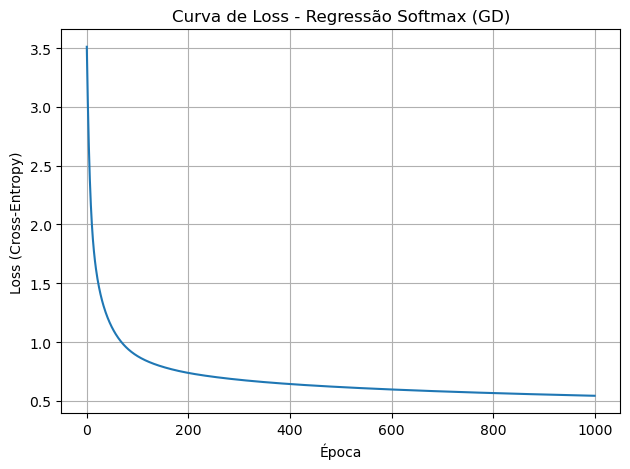

In [20]:
model_final = SoftmaxRegressionGD(alpha=1e-1, num_epochs=1000)
model_final.fit(X, y)

plt.plot(model_final.losses)
plt.xlabel("Época")
plt.ylabel("Loss (Cross-Entropy)")
plt.title("Curva de Loss - Regressão Softmax (GD)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
y_test_pred = model_final.predict(X_test)
test_acc = accuracy(y_test, y_test_pred)
test_accs = per_class_accuracy(y_test, y_test_pred)

print(f"\n[CONJUNTO DE TESTE] Regressão Softmax - GD (Multiclasse)")
print(f"Acurácia Global: {test_acc:.4f}")
for cls, acc in test_accs.items():
    print(f"Acurácia Classe {cls}: {acc:.4f}")


[CONJUNTO DE TESTE] Regressão Softmax - GD (Multiclasse)
Acurácia Global: 0.7165
Acurácia Classe 0: 0.9286
Acurácia Classe 1: 0.5412
Acurácia Classe 2: 0.6032
Acurácia Classe 3: 0.9200


## Análise do discriminante Gaussiano - GDA

In [22]:
print("Análise Discriminante Gaussiana")
print(f"\n[CONJUNTO DE VALIDAÇÃO]")	

accuracies, accs_por_classe = cross_validate_model(
    GaussianDiscriminantAnalysis, 
    X, y, 
    k=10
)

Análise Discriminante Gaussiana

[CONJUNTO DE VALIDAÇÃO]
Fold 1 - Acurácia global: 0.7765 | Acurácia por classe: Classe 0: 0.9583 | Classe 1: 0.5385 | Classe 2: 0.5385 | Classe 3: 1.0000
Fold 2 - Acurácia global: 0.7765 | Acurácia por classe: Classe 0: 0.9643 | Classe 1: 0.5882 | Classe 2: 0.5000 | Classe 3: 1.0000
Fold 3 - Acurácia global: 0.8353 | Acurácia por classe: Classe 0: 1.0000 | Classe 1: 0.8235 | Classe 2: 0.5417 | Classe 3: 1.0000
Fold 4 - Acurácia global: 0.8000 | Acurácia por classe: Classe 0: 0.9412 | Classe 1: 0.6522 | Classe 2: 0.7692 | Classe 3: 0.8947
Fold 5 - Acurácia global: 0.7765 | Acurácia por classe: Classe 0: 0.9565 | Classe 1: 0.6250 | Classe 2: 0.6000 | Classe 3: 0.9444
Fold 6 - Acurácia global: 0.8471 | Acurácia por classe: Classe 0: 0.9600 | Classe 1: 0.6250 | Classe 2: 0.6000 | Classe 3: 1.0000
Fold 7 - Acurácia global: 0.7738 | Acurácia por classe: Classe 0: 0.9474 | Classe 1: 0.5294 | Classe 2: 0.6522 | Classe 3: 0.9200
Fold 8 - Acurácia global: 0.7857 

In [23]:
model_final = GaussianDiscriminantAnalysis()
model_final.fit(X_trainval, y_trainval)

y_test_pred = model_final.predict(X_test)

acc_test = accuracy(y_test, y_test_pred)
accs_test = per_class_accuracy(y_test, y_test_pred)

print(f"\n[CONJUNTO DE TESTE] GDA - Multiclasse")
print(f"Acurácia no teste: {acc_test:.4f}")
print("Acurácia por classe no teste:")
for cls, acc in accs_test.items():
    print(f"Classe {cls}: {acc:.4f}")



[CONJUNTO DE TESTE] GDA - Multiclasse
Acurácia no teste: 0.7244
Acurácia por classe no teste:
Classe 0: 0.9464
Classe 1: 0.5176
Classe 2: 0.6190
Classe 3: 0.9600


## Naive Bayes Gaussiano;

In [24]:
print("Naive Bayes Gaussiano")
print(f"\n[CONJUNTO DE VALIDAÇÃO]")	

accuracies, accs_por_classe = cross_validate_model(GaussianNaiveBayes, X_trainval, y_trainval, k=10)

Naive Bayes Gaussiano

[CONJUNTO DE VALIDAÇÃO]
Fold 1 - Acurácia global: 0.4833 | Acurácia por classe: Classe 0: 0.2857 | Classe 1: 0.1667 | Classe 2: 0.6000 | Classe 3: 0.7857
Fold 2 - Acurácia global: 0.5000 | Acurácia por classe: Classe 0: 0.1875 | Classe 1: 0.0909 | Classe 2: 0.6667 | Classe 3: 1.0000
Fold 3 - Acurácia global: 0.5254 | Acurácia por classe: Classe 0: 0.3529 | Classe 1: 0.3333 | Classe 2: 0.5333 | Classe 3: 0.8667
Fold 4 - Acurácia global: 0.4576 | Acurácia por classe: Classe 0: 0.2778 | Classe 1: 0.2308 | Classe 2: 0.6154 | Classe 3: 0.7333
Fold 5 - Acurácia global: 0.5593 | Acurácia por classe: Classe 0: 0.3846 | Classe 1: 0.2500 | Classe 2: 0.6875 | Classe 3: 0.9286
Fold 6 - Acurácia global: 0.4068 | Acurácia por classe: Classe 0: 0.3125 | Classe 1: 0.1250 | Classe 2: 0.4167 | Classe 3: 0.8000
Fold 7 - Acurácia global: 0.5424 | Acurácia por classe: Classe 0: 0.3333 | Classe 1: 0.3750 | Classe 2: 0.5385 | Classe 3: 0.9333
Fold 8 - Acurácia global: 0.5763 | Acurácia

In [25]:
model_final = GaussianNaiveBayes()
model_final.fit(X_trainval, y_trainval)

y_test_pred = model_final.predict(X_test)

acc_test = accuracy(y_test, y_test_pred)
accs_test = per_class_accuracy(y_test, y_test_pred)

print(f"\n[CONJUNTO DE TESTE] Naive Bayes Gaussiano - Multiclasse")
print(f"Acurácia no teste: {acc_test:.4f}")
print("Acurácia por classe no teste:")
for cls, acc in accs_test.items():
    print(f"Classe {cls}: {acc:.4f}")



[CONJUNTO DE TESTE] Naive Bayes Gaussiano - Multiclasse
Acurácia no teste: 0.4331
Acurácia por classe no teste:
Classe 0: 0.1607
Classe 1: 0.2471
Classe 2: 0.5873
Classe 3: 0.8600
